In [1]:
import random
import copy
import time
import pandas as pd
import numpy as np
import gc
import re
import torch

#import spacy
from tqdm import tqdm_notebook, tnrange
from tqdm.auto import tqdm

tqdm.pandas(desc='Progress')
from collections import Counter

import nltk
from nltk import word_tokenize

import matplotlib.pyplot as plt

In [2]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kajud\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kajud\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kajud\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
df_purged = pd.read_csv("data/Movies_and_TV_5_purged.csv")
df_purged = df_purged.dropna()

In [3]:
len(df_purged)

3408421

In [20]:
df_purged.head()

,Unnamed: 0,reviewText,overall,label
0,0,"[sorry, purchase, years, ago, first, came, goo...",5.0,2.0
1,1,"[believe, tell, receive, blessing, watching, v...",5.0,2.0
2,2,"[seen, live, many, times, early, days, recent,...",5.0,2.0
3,3,"[excited, finally, live, concert, video, seen,...",5.0,2.0
4,4,"[one, best, punk, bands, ever, even, like, cal...",5.0,2.0


In [5]:
# check how balanced the training dataset is
df_purged.groupby(['label']).count()

,Unnamed: 0,reviewText,overall
label,,,
0.0,365517,365517,365517
1.0,349638,349638,349638
2.0,2693266,2693266,2693266


In [5]:
from nltk.corpus import stopwords
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

In [6]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [9]:
import re
import string

# remove emojis: https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

# data preprocessing
def preprocess_text(text):
    
    stop_words = set(stopwords.words('english'))
    # replacing url-s with the word 'url'
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','', text)
    # replacing usernames-s with the word 'user'
    text = re.sub('@[^\s]+','', text)
    # converting text to lowercase
    text = text.lower()
    # remove HTML tags
    text = re.sub('<.*?>', '', text)
    # remove punctuation marks
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    # remove multiple spaces
    text = re.sub(' +',' ', text)
    # replacing numbers with the word 'number'
    text = re.sub(r'\w*\d+\w*', '', text)
    
    tokens = word_tokenize(text)
    
    cleaned_text = [w for w in tokens if not w.lower() in stop_words]
    
    cleaned_text = [w for w in cleaned_text if len(w)>2]

    # text = deEmojify(text)
    
    return cleaned_text


In [10]:
# df_purged["reviewText"] = [replace_contractions(t) for t in tqdm(df_purged.reviewText)]
text_prep = [preprocess_text(t) for t in tqdm(df_purged.reviewText)]
# test_list = [preprocess_text(t) for t in tqdm(df_purged.reviewText[500:1000])]

  0%|          | 0/3408421 [00:00<?, ?it/s]

In [17]:
df_purged["reviewText"] = text_prep

In [31]:
df_purged.to_pickle("data/Movies_and_TV_5_prep_tokenized.pkl")

In [2]:
df_purged = pd.read_pickle("data/Movies_and_TV_5_prep_tokenized.pkl")

# Determining reasonable maximum sentence length (eliminating outliers)

In [3]:
df_purged['len'] = df_purged['reviewText'].apply(lambda s : len(s))

<AxesSubplot:ylabel='Frequency'>

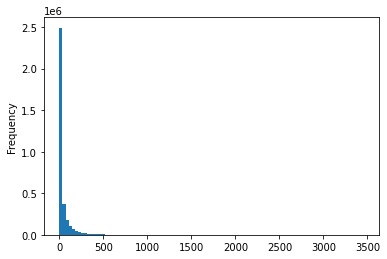

In [4]:
df_purged['len'].plot.hist(bins=100)

In [5]:
df_purged.len.quantile(0.9)

113.0